In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from connector import tableau_db_params

ModuleNotFoundError: No module named 'psycopg2'

In [2]:
pg_conn = psycopg2.connect(**tableau_db_params)

NameError: name 'psycopg2' is not defined

In [2]:
pip install plotly

^C
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/df/79/c80174d711ee26ee5da55a9cc3e248f1ec7a0188b5e4d6bbbbcd09b974b0/plotly-5.17.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/f4/f1/990741d5bb2487d529d20a433210ffa136a367751e454214013b441c4575/tenacity-8.2.3-py3-none-any.whl.metadata
   ---------------------------------------- 15.6/15.6 MB 38.6 MB/s eta 0:00:00


In [4]:
dc_query = '''

   SELECT
    CASE
        WHEN d.db_class = 'hyper' THEN 'Is Extract File'
        WHEN d.refreshable_extracts = 'true' THEN 'Has Extract'
        ELSE 'Live'
    END AS ConnectionType,
    SUM(1) AS TotalCount
FROM
    datasources AS d
WHERE
    d.db_class IN ('hyper', 'sqlserver', 'mysql', 'oracle', 'postgresql') -- Add the database types you want to monitor
GROUP BY
    ConnectionType;




'''

dc_df = pd.read_sql_query(dc_query, pg_conn)
dc_df

,connectiontype,totalcount
0,Live,1
1,Has Extract,8
2,Is Extract File,6


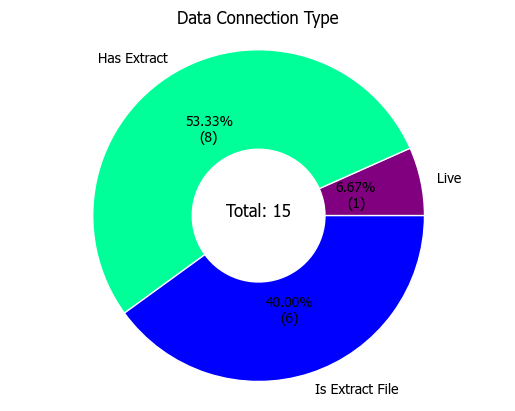

In [27]:
import matplotlib.pyplot as plt

total_count = dc_df['totalcount'].sum()
dc_df['labels'] = dc_df['connectiontype']

def formatfunc(pct, allvals):
    absolute = int(pct/100.*total_count)
    return f"{pct:.2f}%\n({absolute})"

fig, ax = plt.subplots()

# Define colors for the pie chart
colors = ['purple', '#00FF99', 'blue']

# Create the pie chart with custom colors
wedges, texts, autotexts = ax.pie(
    dc_df['totalcount'], 
    labels=dc_df['labels'],
    autopct=lambda pct: formatfunc(pct, dc_df['totalcount']),
    wedgeprops={'width': 0.6, 'edgecolor': 'w'},
    colors=colors  # Set the custom colors here
)

# Set the title
ax.set_title('Data Connection Type')

# Calculate the center coordinates
x_center = 0
y_center = 0

# Display the total count in the center
ax.text(x_center, y_center, f"Total: {total_count}", size=12, color='black', ha='center')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


[None, None, None]

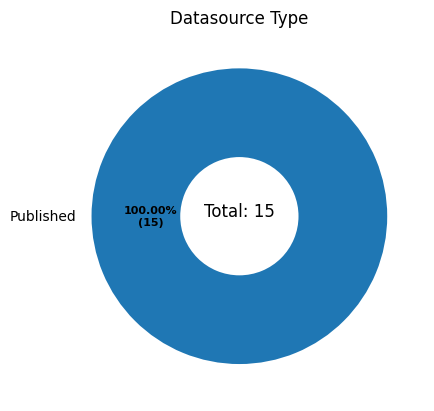

In [183]:
ex_df.index = ex_df['connection_origin']
# ex_df['percent'] = ex_df['totalcount']/ex_df['count'].sum()

def formatfunc(pct, allvals):
    absolute = int(pct/100.*total_count)
    return f"{pct:.2f}%\n({absolute})"

fig, ax = plt.subplots()
wedges, texts, autotexts  = ax.pie(ex_df['count'], labels=ex_df['connection_origin'],autopct=lambda pct: formatfunc(pct, ex_df['count']),wedgeprops=dict(width=0.6
))
ax.set_title('Datasource Type')
# ax.legend(wedges, ex_df['connection_origin'],
#           title="Ingredients",
#           loc="center left",
#           bbox_to_anchor=(1, 0, 0.5, 1))
x_center = 0
y_center = 0
ax.text(x_center, y_center, f"Total: {total_count}", size=12, color='black', ha='center')

plt.setp(autotexts, size=8, weight="bold")

In [6]:
st_query = '''


select
dc.dbclass ,
    CASE
        WHEN dc.dbclass = 'hyper' THEN 'Is Extract File'
        WHEN dc.has_extract = 'true' THEN 'Refreshable Extract'
        ELSE 'Live'
    END AS ConnectionType,
    COUNT(*) AS ConnectionCount
FROM
    data_connections AS dc
WHERE
    dc.dbclass IN ('google-sheets', 'webdata-direct', 'webdata-direct:wdc-arcgis-server', 'hadoophive', 'postgres', 'hyper', 'textscan', 'sqlserver', 'impala', 'excel-direct', 'ogrdirect') -- Specify the database types you want to include
GROUP BY
    ConnectionType,dc.dbclass
ORDER BY
    ConnectionType;


'''
st_df = pd.read_sql_query(st_query, pg_conn)
st_df

,dbclass,connectiontype,connectioncount
0,hyper,Is Extract File,6
1,excel-direct,Live,24
2,textscan,Live,8
3,hadoophive,Live,3
4,postgres,Live,3
5,sqlserver,Live,1
6,ogrdirect,Live,2
7,google-sheets,Refreshable Extract,7
8,ogrdirect,Refreshable Extract,16
9,impala,Refreshable Extract,1


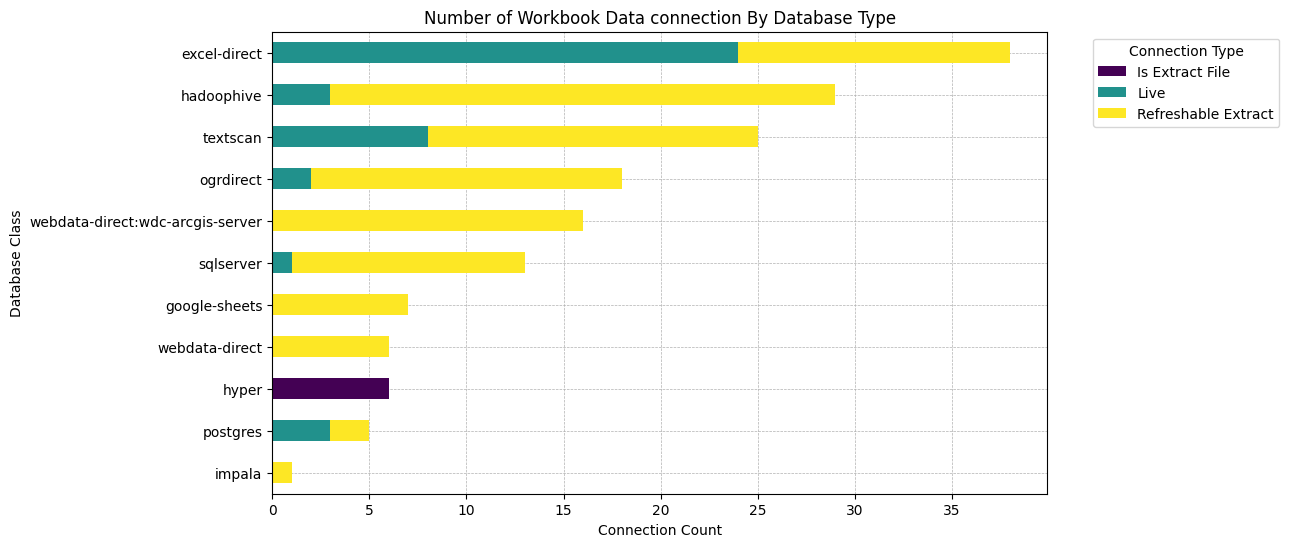

In [7]:
pivoted_df = st_df.pivot(index='dbclass', columns='connectiontype', values='connectioncount').fillna(0)


# Calculate total connection count for each database class
pivoted_df['Total'] = pivoted_df.sum(axis=1)

# Sort the dataframe by total connection count
pivoted_df = pivoted_df.sort_values(by='Total', ascending=True)

# Create the stacked horizontal bar chart
ax = pivoted_df.drop(columns='Total').plot(kind='barh', stacked=True, colormap='viridis', figsize=(10, 6))
plt.xlabel('Connection Count')
plt.ylabel('Database Class')
plt.title('Number of Workbook Data connection By Database Type')

# Show the legend
plt.legend(title='Connection Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add dashed grid lines
ax.set_axisbelow(True)
ax.grid(linestyle='--', linewidth=0.5)

# Show the chart
plt.show()

# line chart (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

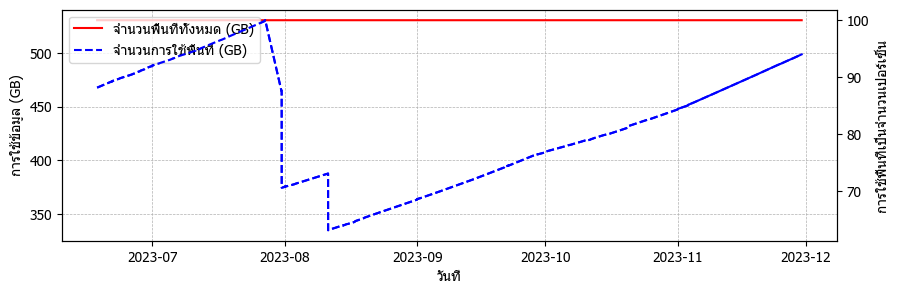

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import requests
from urllib.parse import urlparse, parse_qs

url = "http://localhost:1234/report-service/api/v1/tableau/Disk_lineplot_Usage?month=11&year=2023"

# แยกพารามิเตอร์จาก URL
parsed_url = urlparse(url)

# ดึงค่าเดือนจากพารามิเตอร์
is_month = int(parse_qs(parsed_url.query).get('month', [])[0])

# Add Bearer token to the request headers
headers = {
    'Authorization': 'Bearer POPPOPNIX',  # Replace '1234' with your actual token
}

# Fetch JSON data from the URL with headers
response = requests.get(url, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    json_data = response.json()
    
    # Extract the 'data' key from the JSON data
    data_list1 = json_data.get('total_runs', {}).get('data', [])

    # Create a DataFrame from the list of dictionaries
    disk_df = pd.DataFrame(data_list1)
    
    # Now you can use the DataFrame 'disk_df' for further analysis or visualization
else:
    print(f"Error: {response.status_code}")
def bytes_to_gb(bytes):
    gb = bytes / (1024 ** 3)
    return gb

disk_df['total_space_gb'] = disk_df['total_space_bytes'].map(bytes_to_gb)
disk_df['used_space_gb'] = disk_df['used_space_bytes'].map(bytes_to_gb)

disk_df['record_timestamp'] = pd.to_datetime(disk_df['record_timestamp'])
disk_df = disk_df.sort_values('record_timestamp')

# Check if the month is October
is_october = disk_df['record_timestamp'].dt.month == is_month

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 3))

# Plot the total space on the first axis
ax1.plot(disk_df['record_timestamp'], disk_df['total_space_gb'], 'r', label='จำนวนพื้นที่ทั้งหมด (GB)')

# Plot the used space on the first axis
ax1.plot(disk_df['record_timestamp'], disk_df['used_space_gb'], 'b--', label='จำนวนการใช้พื้นที่ (GB)')

ax1.set_xlabel('วันที่')
ax1.set_ylabel('การใช้ข้อมูล (GB)')

# Create a secondary axis for the percentage
ax2 = ax1.twinx()
plt.rcParams['font.family'] = 'Tahoma'

# Calculate the used space percentage
used_space_percentage = (disk_df['used_space_bytes'] / disk_df['total_space_bytes']) * 100

# Plot the used space percentage on the secondary axis
if is_october.any():
    ax2.plot(disk_df[is_october]['record_timestamp'], used_space_percentage[is_october], 'b')
if (~is_october).any():
    ax2.plot(disk_df[~is_october]['record_timestamp'], used_space_percentage[~is_october], 'b--')

ax2.set_ylabel('การใช้พื้นที่เป็นจำนวนเปอร์เซ็น')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')

ax1.set_axisbelow(True)
ax1.grid(linestyle='--', linewidth=0.5)

plt.show()

# performace bar (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

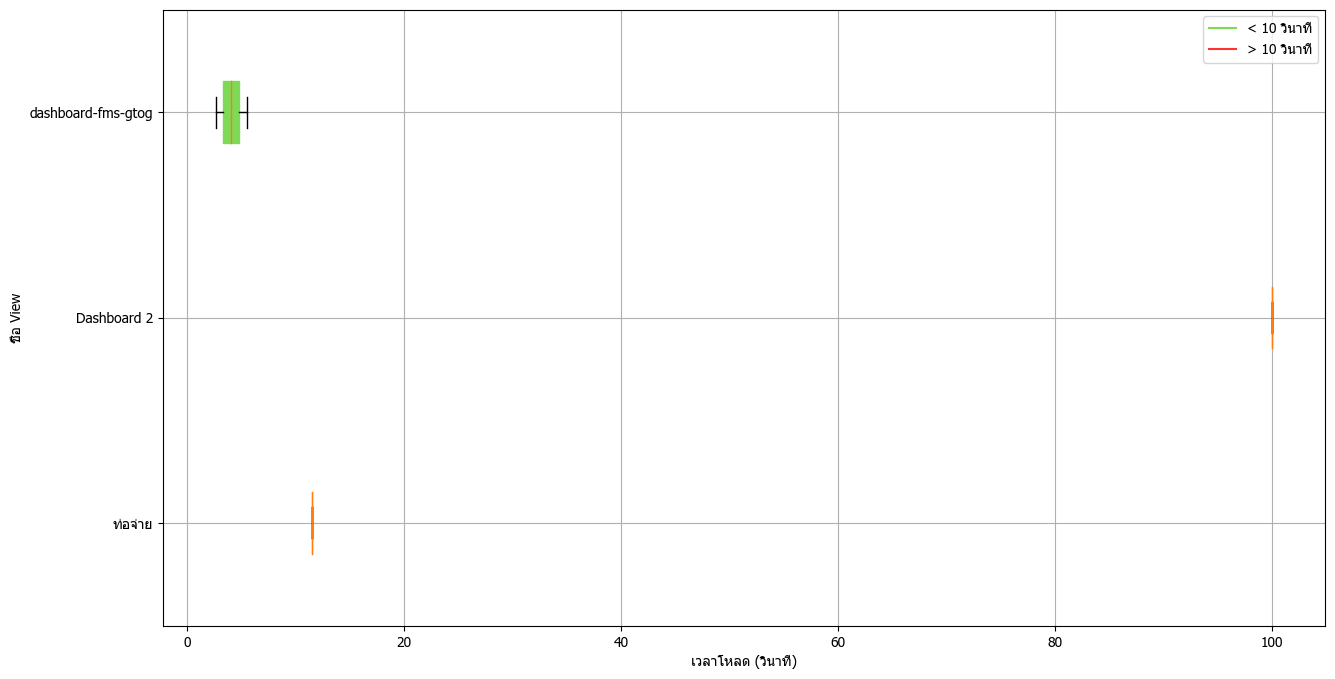

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Specify the URL to fetch JSON data
url = "http://localhost:1234/report-service/api/v1/tableau/Get_Performace_Dashboard?month=12&year=2023"

# Add Bearer token to the request headers
headers = {
    'Authorization': 'Bearer POPPOPNIX',  # Replace '1234' with your actual token
}

# Fetch JSON data from the URL with headers
response = requests.get(url, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    json_data = response.json()
    
    # Extract the 'data' key from the JSON data
    data_list1 = json_data.get('total_runs', {}).get('data', [])

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data_list1)

# Assuming you have a DataFrame called 'data' with the provided data

# Calculate the IQR (Interquartile Range) for elapsed_time_sec
Q1 = df['elapsed_time_sec'].quantile(0.25)
Q3 = df['elapsed_time_sec'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove outliers
filtered_data = df
plt.rcParams['font.family'] = 'Tahoma'

# Sort the View Names by count of data points (records)
sorted_view_names = filtered_data['name'].value_counts().head(10).index

# Create a boxplot for each View Name and stack them together
fig, ax = plt.subplots(figsize=(15, 8))
boxplot_data = [filtered_data[filtered_data['name'] == view_name]['elapsed_time_sec'] for view_name in sorted_view_names]

# Set the boxplot colors
default_color = '#7ED957'
colors = [default_color if view_name != 'รายงานวิเคราะห์ข้อมูลท่อรั่วราย DMA' else '#FF3131' for view_name in sorted_view_names]

bp = ax.boxplot(boxplot_data, vert=False, labels=sorted_view_names, showfliers=False, patch_artist=True)

# Loop through the boxplots to set the box colors
for box, color in zip(bp['boxes'], colors):
    box.set(facecolor=color, color=color)

ax.set_xlabel('เวลาโหลด (วินาที)')
ax.set_ylabel('ชื่อ View')

ax.invert_yaxis()

# Create custom legend entries
legend_elements = [mlines.Line2D([], [], color=default_color, label='< 10 วินาที'),
                   mlines.Line2D([], [], color='#FF3131', label='> 10 วินาที')]

# Add legend
ax.legend(handles=legend_elements)

# ax.set_title('Load time of top 10 most view dashboards')
ax.grid()
ax.get_axisbelow()

plt.show()


# Extracts Dot (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

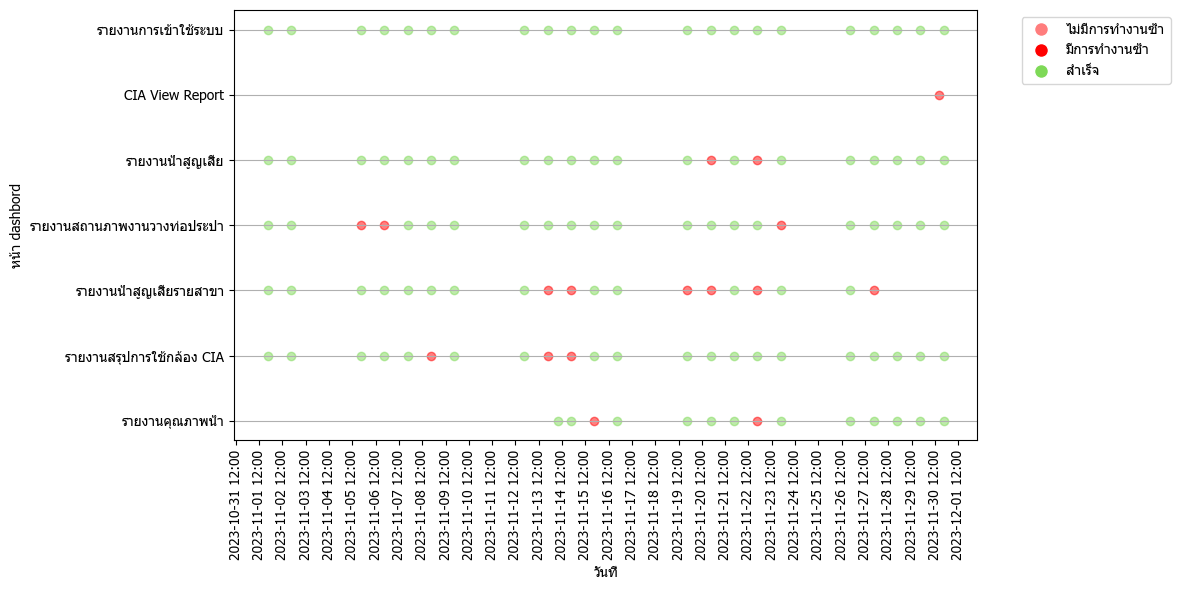

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# Define the path to your JSON file
json_file_path = r'C:\work_on_maholan\mhl-de-ma-report\json_file\Extracts_dot_m11.json'

# Read JSON file into DataFrame
df = pd.read_json(json_file_path)

# Convert the 'Started At' column to a datetime type
df['Started At'] = pd.to_datetime(df['Started At'])

# Filter the DataFrame to include "Error" and "Success" status
error_df = df[df['Status of Job'] == 'Error']
success_df = df[df['Status of Job'] == 'Success']

# Create the scatter plot for "Error" status
plt.figure(figsize=(12, 6))
error_color = 'red'  # Color for "Error" data points
plt.scatter(error_df['Started At'], error_df['Extract'], c=error_color, label='มีการทำงานซ้ำ', alpha=0.5)

# Create the scatter plot for "Success" status
success_color = '#7ED957'  # Color for "Success" data points
plt.scatter(success_df['Started At'], success_df['Extract'], c=success_color, label='สำเร็จ', alpha=0.5)

# Customize the plot
plt.xlabel('วันที่')
plt.ylabel('หน้า dashbord')
plt.grid(axis='y')

# Set the x-axis format to show ticks at 12-hour intervals
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=90)

# Define the custom legend using Line2D
custom_legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF7D7D', markersize=10, label='ไม่มีการทำงานซ้ำ'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF0000', markersize=10, label='มีการทำงานซ้ำ'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#7ED957', markersize=10, label='สำเร็จ')
]

# Place the legend outside the plot
plt.legend(handles=custom_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of the legend
plt.show()


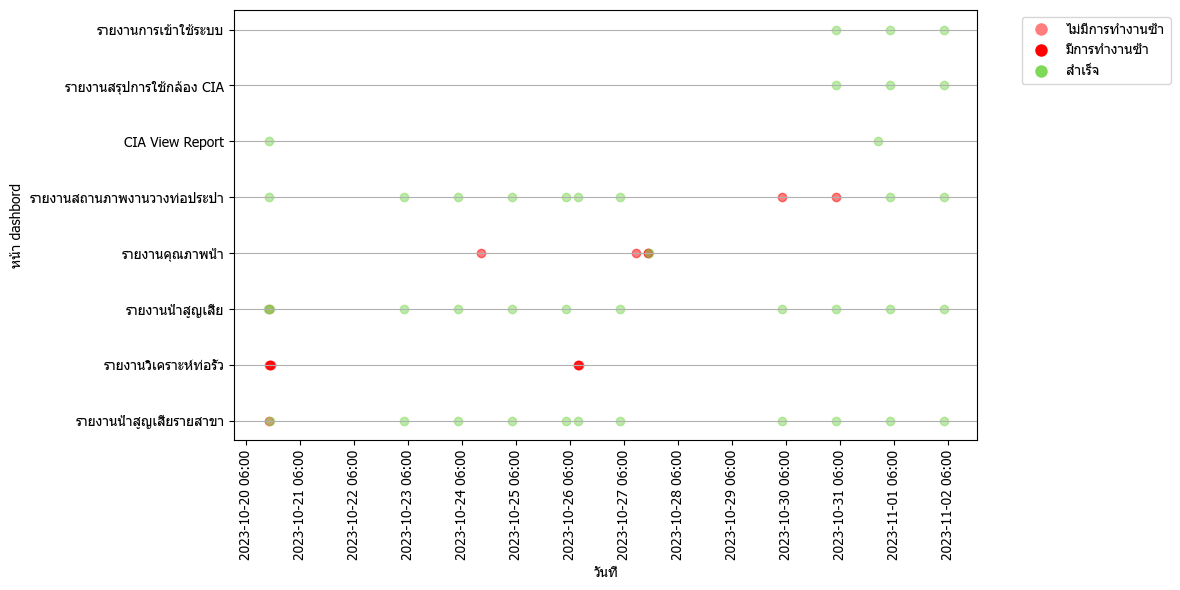

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# Define the path to your JSON file
json_file_path = r'C:\work_on_maholan\mhl-de-ma-report\json_file\Extracts_dot_m10.json'

# Read JSON file into DataFrame
df = pd.read_json(json_file_path)

# Convert the 'Started At' column to a datetime type
df['Started At'] = pd.to_datetime(df['started_at_local'])

# Filter the DataFrame to include "Error" and "Success" status
error_df = df[df['Status of Job'] == 'Error']
success_df = df[df['Status of Job'] == 'Success']

# Create the scatter plot for "Error" status
plt.figure(figsize=(12, 6))import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# Assuming df is your DataFrame containing the necessary columns

# Convert the 'created_at_local' column to a datetime type
df['created_at_local'] = pd.to_datetime(df['created_at_local'])

# Filter the DataFrame to include "Error" and "Success" status
error_df = df[df['status_job'] == 'failure']  # Assuming 'failure' corresponds to 'Error'
success_df = df[df['status_job'] == 'success']  # Assuming 'success' corresponds to 'Success'

# Create the scatter plot for "Error" status
plt.figure(figsize=(12, 6))
error_color = 'red'  # Color for "Error" data points
plt.scatter(error_df['created_at_local'], error_df['title'], c=error_color, label='มีการทำงานซ้ำ', alpha=0.5)

# Create the scatter plot for "Success" status
success_color = '#7ED957'  # Color for "Success" data points
plt.scatter(success_df['created_at_local'], success_df['title'], c=success_color, label='สำเร็จ', alpha=0.5)

# Customize the plot
plt.xlabel('วันที่')
plt.ylabel('หน้า dashboard')
plt.grid(axis='y')

# Set the x-axis format to show ticks at 12-hour intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjusted to show ticks at daily intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=90)

# Define the custom legend using Line2D
custom_legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF0000', markersize=10, label='มีการทำงานซ้ำ'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#7ED957', markersize=10, label='สำเร็จ')
]

# Place the legend outside the plot
plt.legend(handles=custom_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of the legend
plt.show()

error_color = 'red'  # Color for "Error" data points
plt.scatter(error_df['Started At'], error_df['Extract'], c=error_color, label='มีการทำงานซ้ำ', alpha=0.5)

# Create the scatter plot for "Success" status
success_color = '#7ED957'  # Color for "Success" data points
plt.scatter(success_df['Started At'], success_df['Extract'], c=success_color, label='สำเร็จ', alpha=0.5)

# Customize the plot
plt.xlabel('วันที่')
plt.ylabel('หน้า dashbord')
plt.grid(axis='y')

# Set the x-axis format to show ticks at 12-hour intervals
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=90)

# Define the custom legend using Line2D
custom_legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF7D7D', markersize=10, label='ไม่มีการทำงานซ้ำ'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF0000', markersize=10, label='มีการทำงานซ้ำ'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#7ED957', markersize=10, label='สำเร็จ')
]

# Place the legend outside the plot
plt.legend(handles=custom_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of the legend
plt.show()


,created_at_local,id,extract,completed_at_local_nonull,backgrounder_id,completed_at_local,job_name,notes,priority,processed_on_worker,started_at_local,status_job,title,exetract_task,site,finish_code,progress
0,2023-11-22 04:00:05.208,5698891,Sheet 1,2023-11-22 04:00:25.016,localhost:1:0,2023-11-22 04:00:25.016,Refresh Extracts,None,50,localhost,2023-11-22 04:00:16.862,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
1,2023-11-22 04:00:05.208,5698891,Dashboard 1,2023-11-22 04:00:25.016,localhost:1:0,2023-11-22 04:00:25.016,Refresh Extracts,None,50,localhost,2023-11-22 04:00:16.862,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
2,2023-11-22 04:00:05.208,5698891,Sheet 1,2023-11-22 04:00:25.016,localhost:1:0,2023-11-22 04:00:25.016,Refresh Extracts,None,50,localhost,2023-11-22 04:00:16.862,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
3,2023-11-22 04:00:05.208,5698891,Overview,2023-11-22 04:00:25.016,localhost:1:0,2023-11-22 04:00:25.016,Refresh Extracts,None,50,localhost,2023-11-22 04:00:16.862,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
4,2023-11-22 04:00:05.208,5698891,Dashboard.01,2023-11-22 04:00:25.016,localhost:1:0,2023-11-22 04:00:25.016,Refresh Extracts,None,50,localhost,2023-11-22 04:00:16.862,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,2023-11-28 04:00:24.326,5752134,Line graph,2023-11-28 04:00:49.363,localhost:1:1,2023-11-28 04:00:49.363,Refresh Extracts,None,50,localhost,2023-11-28 04:00:33.943,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
2651,2023-11-28 04:00:24.326,5752134,Line (4),2023-11-28 04:00:49.363,localhost:1:1,2023-11-28 04:00:49.363,Refresh Extracts,None,50,localhost,2023-11-28 04:00:33.943,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
2652,2023-11-28 04:00:24.326,5752134,Line (3),2023-11-28 04:00:49.363,localhost:1:1,2023-11-28 04:00:49.363,Refresh Extracts,None,50,localhost,2023-11-28 04:00:33.943,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
2653,2023-11-28 04:00:24.326,5752134,pie,2023-11-28 04:00:49.363,localhost:1:1,2023-11-28 04:00:49.363,Refresh Extracts,None,50,localhost,2023-11-28 04:00:33.943,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100


# spec_use_donut (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

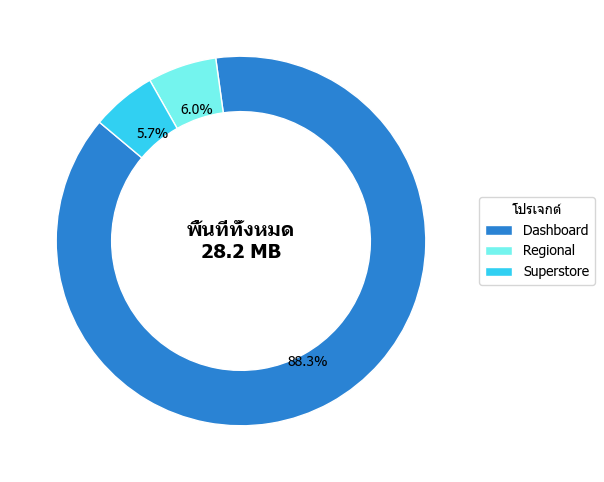

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Specify the URL to fetch JSON data
url = "http://localhost:1234/report-service/api/v1/tableau/Top5_Space_Usage_By_Workbook"

# Add Bearer token to the request headers
headers = {
    'Authorization': 'Bearer POPPOPNIX',  # Replace '1234' with your actual token
}

# Fetch JSON data from the URL with headers
response = requests.get(url, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    json_data = response.json()
    
    # Extract the 'data' key from the JSON data
    data_list1 = json_data['data']

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data_list1)
# หาคอลัมน์ที่คุณต้องการสร้าง Donut Chart
project_sizes = df.groupby('name_workbook')['size in MB'].sum()

# กำหนดสีสำหรับ Donut Chart
colors = ['#2A83D4','#74F4EE','#31D0F2']
plt.rcParams['font.family'] = 'Tahoma'

# สร้าง Donut Chart ที่เล็กลงและไม่มีเงา
plt.figure(figsize=(6, 6))

# เพิ่มขนาดตัวเลขและรูปแบบตามที่คุณต้องการ
autopct_format = '%.1f%%'

# เพิ่ม pctdistance เพื่อควบคุมความห่างของค่าเปอร์เซ็นต์จากวงกลม
plt.pie(project_sizes, labels=None, autopct=autopct_format, colors=colors, startangle=140, wedgeprops=dict(width=0.3, edgecolor='w'), pctdistance=0.75)

# เพิ่มขนาดตัวเลขเปอร์เซ็นต์
total_size = project_sizes.sum()
center_text = f'พื้นที่ทั้งหมด\n{total_size:.1f} MB'

# เพิ่มขนาดรูโดนัดและขนาดตัวอักษร
plt.text(0, 0, center_text, ha='center', va='center', fontsize=14, color='black', fontweight='bold')
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.5, color='white'))

# สร้างเลเบลจากข้อมูลในคอลัมน์ 'Project'
plt.legend(project_sizes.index, title="โปรเจกต์", bbox_to_anchor=(1, 0.5), loc='center left')

# ลบเงา
plt.gca().set_aspect('equal')
plt.gca().set_frame_on(False)

# แสดงกราฟ
plt.show()

In [59]:

st_query = '''



    
    SELECT
        bj.created_at AS created_at_local,
        bj.id AS ID,
        v.name AS Extract,
        bj.completed_at AS completed_at_local_nonull,
        bj.backgrounder_id AS Backgrounder_Id,
        bj.completed_at AS completed_at_local,
        bj.job_name AS Job_Name,
        aj.notes AS Notes,
        bj.priority AS Priority,
        bj.processed_on_worker AS Processed_On_Worker,
        bj.started_at AS started_at_local,
        CASE
            WHEN bj.finish_code = 0 THEN 'success'
            WHEN bj.finish_code = 1 THEN 'failure'
            WHEN bj.finish_code = 2 THEN 'cancelled'
            ELSE 'unknown'
        END AS status_job,
        bj.title AS Title,
        bj.job_name AS exetract_task,
        s.name AS Site,
        bj.finish_code as finish_code,
        bj.progress AS progress
    FROM
        background_jobs bj
    LEFT JOIN sites s ON bj.site_id = s.id
    LEFT JOIN views v ON s.id = v.site_id
    LEFT JOIN async_jobs aj ON s.id = aj.site_id
    WHERE 
        Job_Name = 'Refresh Extracts' AND
        EXTRACT(MONTH FROM bj.created_at) = 11 AND 
        EXTRACT(YEAR FROM bj.created_at) = 2023



'''
df = pd.read_sql_query(st_query, pg_conn)
df

,created_at_local,id,extract,completed_at_local_nonull,backgrounder_id,completed_at_local,job_name,notes,priority,processed_on_worker,started_at_local,status_job,title,exetract_task,site,finish_code,progress
0,2023-11-23 04:00:39.592,5707756,Sheet 1,2023-11-23 04:00:58.747,localhost:1:0,2023-11-23 04:00:58.747,Refresh Extracts,None,50,localhost,2023-11-23 04:00:50.326,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
1,2023-11-23 04:00:39.592,5707756,Dashboard 1,2023-11-23 04:00:58.747,localhost:1:0,2023-11-23 04:00:58.747,Refresh Extracts,None,50,localhost,2023-11-23 04:00:50.326,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
2,2023-11-23 04:00:39.592,5707756,Sheet 1,2023-11-23 04:00:58.747,localhost:1:0,2023-11-23 04:00:58.747,Refresh Extracts,None,50,localhost,2023-11-23 04:00:50.326,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
3,2023-11-23 04:00:39.592,5707756,Overview,2023-11-23 04:00:58.747,localhost:1:0,2023-11-23 04:00:58.747,Refresh Extracts,None,50,localhost,2023-11-23 04:00:50.326,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
4,2023-11-23 04:00:39.592,5707756,Dashboard.01,2023-11-23 04:00:58.747,localhost:1:0,2023-11-23 04:00:58.747,Refresh Extracts,None,50,localhost,2023-11-23 04:00:50.326,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,2023-11-29 04:00:55.623,5761003,Line graph,2023-11-29 04:01:23.567,localhost:1:0,2023-11-29 04:01:23.567,Refresh Extracts,None,50,localhost,2023-11-29 04:01:07.860,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
2651,2023-11-29 04:00:55.623,5761003,Line (4),2023-11-29 04:01:23.567,localhost:1:0,2023-11-29 04:01:23.567,Refresh Extracts,None,50,localhost,2023-11-29 04:01:07.860,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
2652,2023-11-29 04:00:55.623,5761003,Line (3),2023-11-29 04:01:23.567,localhost:1:0,2023-11-29 04:01:23.567,Refresh Extracts,None,50,localhost,2023-11-29 04:01:07.860,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100
2653,2023-11-29 04:00:55.623,5761003,pie,2023-11-29 04:01:23.567,localhost:1:0,2023-11-29 04:01:23.567,Refresh Extracts,None,50,localhost,2023-11-29 04:01:07.860,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100


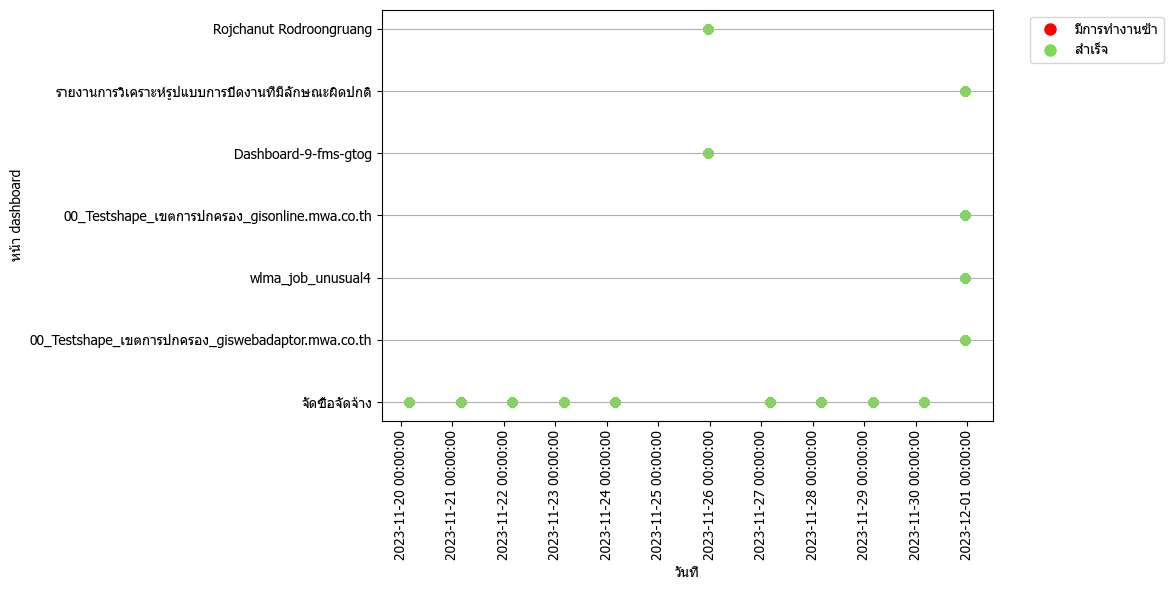

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# Assuming df is your DataFrame containing the necessary columns

# Convert the 'created_at_local' column to a datetime type
df['created_at_local'] = pd.to_datetime(df['created_at_local'])

# Filter the DataFrame to include "Error" and "Success" status
error_df = df[df['status_job'] == 'failure']  # Assuming 'failure' corresponds to 'Error'
success_df = df[df['status_job'] == 'success']  # Assuming 'success' corresponds to 'Success'

# Create the scatter plot for "Error" status
plt.figure(figsize=(12, 6))
error_color = 'red'  # Color for "Error" data points
plt.scatter(error_df['created_at_local'], error_df['title'], c=error_color, label='มีการทำงานซ้ำ', alpha=0.5)

# Create the scatter plot for "Success" status
success_color = '#7ED957'  # Color for "Success" data points
plt.scatter(success_df['created_at_local'], success_df['title'], c=success_color, label='สำเร็จ', alpha=0.5)

# Customize the plot
plt.xlabel('วันที่')
plt.ylabel('หน้า dashboard')
plt.grid(axis='y')

plt.rcParams['font.family'] = 'Tahoma'

# Set the x-axis format to show ticks at 12-hour intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjusted to show ticks at daily intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=90)

# Define the custom legend using Line2D
custom_legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF0000', markersize=10, label='มีการทำงานซ้ำ'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#7ED957', markersize=10, label='สำเร็จ')
]

# Place the legend outside the plot
plt.legend(handles=custom_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of the legend
plt.show()


In [61]:
df['Created At'] = pd.to_datetime(df['created_at_local'])

# Extracting the date with timestamp from the 'Created At' column
df['Date'] = df['Created At'].dt.floor('D')

# Creating the 'Success' and 'Error' columns based on 'Status of Job'
df['Success'] = df['status_job'].apply(lambda x: 1 if x == 'success' else 0)
df['Error'] = df['status_job'].apply(lambda x: 1 if x == 'error' else 0)

# Grouping by 'Date' and aggregating the counts
df2 = df.groupby('Date').agg({
    'Created At': 'first',  # Assuming you want to keep the first timestamp of the day
    'Success': 'sum',
    'Error': 'sum'
}).reset_index()
df2
# Renaming the columns as per your request
df2.rename(columns={'Created At': 'Created At per day'}, inplace=True)

# Convert the 'Date' column to datetime type
df2['Date'] = pd.to_datetime(df2['Date'])

# Converting the 'Date' column to Thai date format with Buddhist Era year
df2['Date'] = df2['Date'].apply(lambda x: f"{x.day}-{x.month}-{x.year + 543}")

# Drop the 'Created At per day' column
df2 = df2.drop(columns=['Created At per day'])

df2.rename(columns={'Date': 'วันที่'}, inplace=True)
df =df2
df

,วันที่,Success,Error
0,20-11-2566,177,0
1,21-11-2566,177,0
2,22-11-2566,177,0
3,23-11-2566,177,0
4,24-11-2566,177,0
5,25-11-2566,354,0
6,27-11-2566,177,0
7,28-11-2566,177,0
8,29-11-2566,177,0
9,30-11-2566,885,0


# Extracts_bar (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

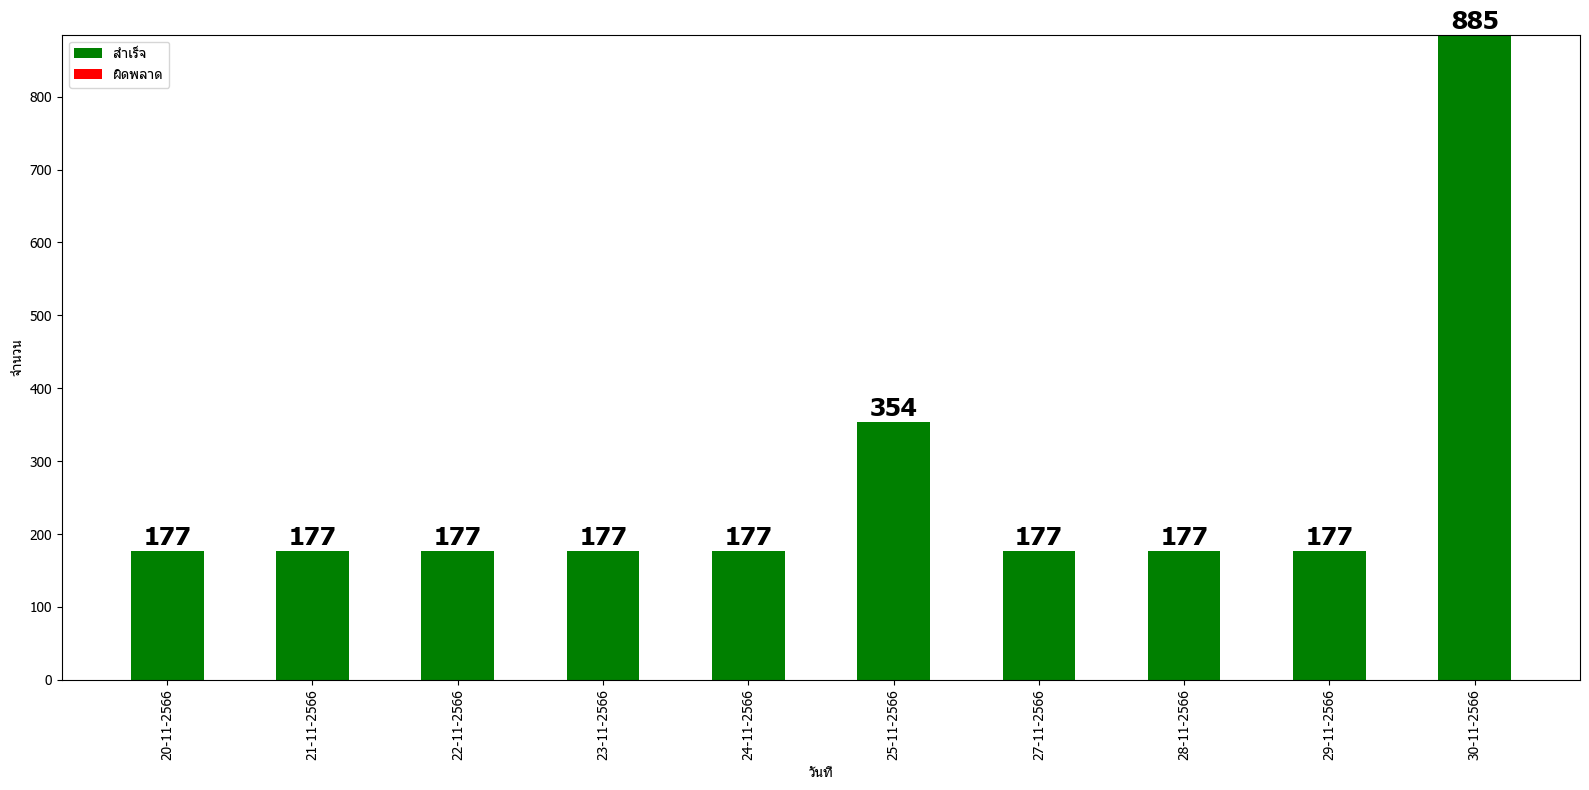

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# อ่านข้อมูลจากไฟล์ CSV
# json_file_path = r'C:\work_on_maholan\mhl-de-ma-report\json_file\Extracts_bar_m11.json'

# Read JSON file into DataFrame
# df = pd.read_json(json_file_path)
# df.fillna(0, inplace=True)

# แทนที่ค่า Error เป็น 0
df['Error'] = df['Error'].replace('0', 0)

# สร้างกราฟ
plt.figure(figsize=(16, 8))  # ปรับขนาดกราฟตามที่คุณต้องการ

# เพิ่ม grid
# plt.grid(True, linestyle='--', alpha=0.6)

# สร้างกราฟแท่งสแต็คบาร์
width = 0.5
x = range(len(df))
success_bars = plt.bar(x, df['Success'], width, label='สำเร็จ', color='g')
error_bars = plt.bar(x, df['Error'], width, label='ผิดพลาด', hatch='', color='red', bottom=df['Success'])

# ปรับแต่งกราฟ
plt.xlabel('วันที่')
plt.ylabel('จำนวน')
plt.rcParams['font.family'] = 'Tahoma'
plt.xticks(x, df['วันที่'], rotation='vertical')  # ปรับแต่งแกน x ให้เป็นแนวตั้ง
plt.legend()

# ระยะห่างด้านบนของกราฟ
top_padding = 1  # เพิ่มระยะห่างด้านบนไปอีก 3 นิ้ว

# แสดงค่า Success ภายในแต่ละแท่ง
# def add_labels(bars, top_padding=0):
#     for bar in bars:
#         height = bar.get_height()
#         plt.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height - top_padding), ha='center', va='bottom', fontsize=17)

# # เรียกใช้งานฟังก์ชันเพื่อแสดงค่า Success
# add_labels(success_bars, top_padding=top_padding)

# เพิ่มระยะห่างด้านบนสำหรับค่าผลรวม
top_sum = 1
# แสดงค่าผลรวมของ Success และ Error ด้านบนกราฟ
for i, (success, error) in enumerate(zip(df['Success'], df['Error'])):
    if pd.notna(success):  # ตรวจสอบว่าค่า Success ไม่ใช่ NaN
        total = success + error
        if pd.notna(total):  # ตรวจสอบว่าค่าผลรวมไม่ใช่ NaN
            # ใช้ int() หรือ str() เพื่อตัดทศนิยม .0
            plt.text(i, total + top_sum, str(int(total)), ha='center', va='bottom', fontweight='bold', fontsize=18)

# แสดงกราฟ
plt.tight_layout()  # ปรับระยะระหว่างกราฟ
plt.show()


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# อ่านข้อมูลจากไฟล์ CSV


# แทนที่ค่า Error เป็น 0
df['Error'] = df['Error'].replace('0', 0)

# สร้างกราฟ
plt.figure(figsize=(16, 8))  # ปรับขนาดกราฟตามที่คุณต้องการ

# เพิ่ม grid
# plt.grid(True, linestyle='--', alpha=0.6)

# สร้างกราฟแท่งสแต็คบาร์
width = 0.5
x = range(len(df))
success_bars = plt.bar(x, df['Success'], width, label='สำเร็จ', color='g', bottom=df['Error'])
error_bars = plt.bar(x, df['Error'], width, label='ผิดพลาด', hatch='', color='red')

# ปรับแต่งกราฟ
plt.xlabel('วันที่')
plt.ylabel('จำนวน')
plt.rcParams['font.family'] = 'Tahoma'
plt.xticks(x, df['วันที่'], rotation='vertical')  # ปรับแต่งแกน x ให้เป็นแนวตั้ง
plt.legend()

# ระยะห่างด้านบนของกราฟ
top_padding = 1  # เพิ่มระยะห่างด้านบนไปอีก 3 นิ้ว

# แสดงค่า Success ภายในแต่ละแท่ง
def add_labels(bars, top_padding=0):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height - top_padding), ha='center', va='top', fontsize=17)

def add_labels(bars, top_padding=0):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height - top_padding), ha='center', va='bottom', fontsize=17)

# เรียกใช้งานฟังก์ชันเพื่อแสดงค่า Success
add_labels(success_bars, top_padding=top_padding)
add_labels(error_bars, top_padding=top_padding)

# เพิ่มระยะห่างด้านบนสำหรับค่าผลรวม
top_sum = 0
# แสดงค่าผลรวมของ Success และ Error ด้านบนกราฟ
for i, (success, error) in enumerate(zip(df['Success'], df['Error'])):
    if pd.notna(success):  # ตรวจสอบว่าค่า Success ไม่ใช่ NaN
        total = success + error
        if pd.notna(total):  # ตรวจสอบว่าค่าผลรวมไม่ใช่ NaN
            # ใช้ int() หรือ str() เพื่อตัดทศนิยม .0
            plt.text(i, total + top_sum, str(int(total)), ha='center', va='bottom', fontweight='bold', fontsize=18)

# แสดงกราฟ
plt.tight_layout()  # ปรับระยะระหว่างกราฟ
plt.show()


,created_at_local,id,extract,completed_at_local_nonull,backgrounder_id,completed_at_local,job_name,notes,priority,processed_on_worker,started_at_local,status_job,title,exetract_task,site,finish_code,progress,Started At
0,2023-11-22 04:00:05.208,5698891,Sheet 1,2023-11-22 04:00:25.016,localhost:1:0,2023-11-22 04:00:25.016,Refresh Extracts,None,50,localhost,2023-11-22 04:00:16.862,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100,2023-11-22 04:00:16.862
1,2023-11-22 04:00:05.208,5698891,Dashboard 1,2023-11-22 04:00:25.016,localhost:1:0,2023-11-22 04:00:25.016,Refresh Extracts,None,50,localhost,2023-11-22 04:00:16.862,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100,2023-11-22 04:00:16.862
2,2023-11-22 04:00:05.208,5698891,Sheet 1,2023-11-22 04:00:25.016,localhost:1:0,2023-11-22 04:00:25.016,Refresh Extracts,None,50,localhost,2023-11-22 04:00:16.862,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100,2023-11-22 04:00:16.862
3,2023-11-22 04:00:05.208,5698891,Overview,2023-11-22 04:00:25.016,localhost:1:0,2023-11-22 04:00:25.016,Refresh Extracts,None,50,localhost,2023-11-22 04:00:16.862,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100,2023-11-22 04:00:16.862
4,2023-11-22 04:00:05.208,5698891,Dashboard.01,2023-11-22 04:00:25.016,localhost:1:0,2023-11-22 04:00:25.016,Refresh Extracts,None,50,localhost,2023-11-22 04:00:16.862,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100,2023-11-22 04:00:16.862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,2023-11-28 04:00:24.326,5752134,Line graph,2023-11-28 04:00:49.363,localhost:1:1,2023-11-28 04:00:49.363,Refresh Extracts,None,50,localhost,2023-11-28 04:00:33.943,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100,2023-11-28 04:00:33.943
2651,2023-11-28 04:00:24.326,5752134,Line (4),2023-11-28 04:00:49.363,localhost:1:1,2023-11-28 04:00:49.363,Refresh Extracts,None,50,localhost,2023-11-28 04:00:33.943,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100,2023-11-28 04:00:33.943
2652,2023-11-28 04:00:24.326,5752134,Line (3),2023-11-28 04:00:49.363,localhost:1:1,2023-11-28 04:00:49.363,Refresh Extracts,None,50,localhost,2023-11-28 04:00:33.943,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100,2023-11-28 04:00:33.943
2653,2023-11-28 04:00:24.326,5752134,pie,2023-11-28 04:00:49.363,localhost:1:1,2023-11-28 04:00:49.363,Refresh Extracts,None,50,localhost,2023-11-28 04:00:33.943,success,จัดซื้อจัดจ้าง,Refresh Extracts,Default,0,100,2023-11-28 04:00:33.943


In [1]:
tdf_query = '''

 select * from historical_disk_usage hdu;


'''


NameError: name 'pd' is not defined

In [ ]:
Size by Project_clean

In [84]:
import psycopg2

# Define your PostgreSQL connection parameters

# Create a connection to the database using the connection parameters
conn = psycopg2.connect(**tableau_db_params)

# Create a cursor to interact with the database
cur = conn.cursor()

# Execute your SQL query
cur.execute("""
WITH all_days AS (
  SELECT generate_series(
    DATE '2022-10-01',
    DATE '2022-10-31',
    INTERVAL '1 day'
  )::DATE AS day
)
SELECT all_days.day,
       COALESCE(COUNT(data_connections.created_at), 0) AS count,
       EXTRACT(DAY FROM all_days.day) AS day_of_month
FROM all_days
LEFT JOIN data_connections ON DATE_TRUNC('day', all_days.day) = DATE_TRUNC('day', data_connections.created_at)
GROUP BY all_days.day
ORDER BY all_days.day;
""")

# Fetch the results
results = cur.fetchall()

# Close the cursor and the database connection
cur.close()
conn.close()


NameError: name 'tableau_db_params' is not defined

In [85]:
import matplotlib.pyplot as plt

# Separate the day of the month and counts from the results
day_of_month = [row[2] for row in results]
count = [int(row[1]) for row in results]  # Convert to integer to remove .0

# Set the figure size and style
plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

# Create a bar graph with a custom background color
plt.bar(day_of_month, count, color='skyblue')  # Set color to sky blue for the bars
plt.xlabel("Day of the Month")
plt.ylabel("Count")
plt.title("Traffic to data of the Month")

# Set x-axis to display all days of the month
plt.xticks(range(1, 32))
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add dashed horizontal grid lines

# Add labels to the bars with adjusted position (c)
for i, c in enumerate(count):
    plt.text(day_of_month[i], c, str(c), ha='center', va='bottom')

# Customize the background color to white
plt.gcf().set_facecolor('white')

plt.show()



NameError: name 'results' is not defined

In [1]:
import psycopg2

# Define your PostgreSQL connection parameters

# Create a connection to the database using the connection parameters
conn = psycopg2.connect(**tableau_db_params)

# Create a cursor to interact with the database
cur = conn.cursor()

# Execute your SQL query
cur.execute("""
WITH view_names AS (
    SELECT id, name
    FROM views
)
SELECT
    vn.view_id,
    vn.total_query_batch_time_in_seconds,
    vn.name,
    vn.count
FROM (
    SELECT
        mvs.view_id,
        mvs.total_query_batch_time_in_seconds,
        vn.name,
        COUNT(*) OVER (PARTITION BY vn.name) AS count
    FROM materialized_views_sheet_performance mvs
    INNER JOIN view_names vn ON mvs.view_id = vn.id
    WHERE mvs.day_timestamp >= '2023-01-01' AND mvs.day_timestamp <= '2023-10-30'
) vn
WHERE vn.count <> 1;
""")

# Fetch the results
results = cur.fetchall()

# Close the cursor and the database connection
cur.close()
conn.close()


NameError: name 'tableau_db_params' is not defined

c:\users\hitle\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\hitle\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\hitle\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3621 (\N{THAI CHARACTER LO LING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\hitle\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\hitle\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.p

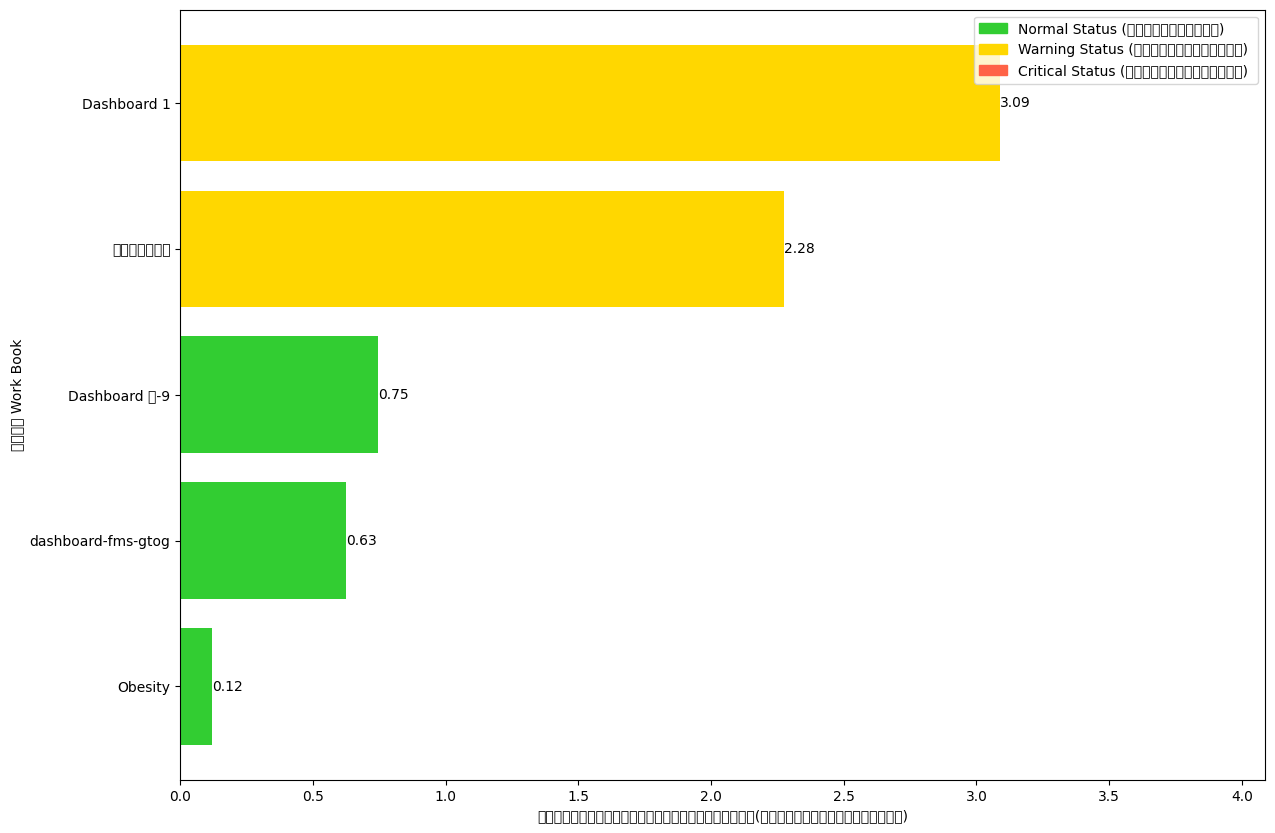

In [129]:
from collections import defaultdict
import matplotlib.pyplot as plt

data = results

data.sort(key=lambda x: x[2])  # Sort the data based on the name

# Use defaultdict to aggregate values and count occurrences of each name
name_to_values = defaultdict(list)
name_to_counts = defaultdict(int)

for _, value, name, _ in data:
    name_to_values[name].append(value)
    name_to_counts[name] += 1

# Calculate the average value for each name
name_to_avg = {name: sum(values) / name_to_counts[name] for name, values in name_to_values.items()}

# Convert the data for the graph and sort it by average value (ascending order)
sorted_names = list(name_to_avg.keys())
sorted_values = list(name_to_avg.values())
sorted_names, sorted_values = zip(*sorted(zip(sorted_names, sorted_values), key=lambda x: x[1]))

# Define color thresholds and their meanings in the get_color function
def get_color(value):
    if value < 1:
        return 'limegreen'
    elif 1 <= value < 5:
        return 'gold'
    else:
        return 'tomato'

# Get colors for each bar based on the values
bar_colors = [get_color(value) for value in sorted_values]

# Create a larger horizontal bar graph
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed

# Set the x-axis limits to start from 0
plt.xlim(0, max(sorted_values) + 1.0)

# Set the x-axis to display values
bars = plt.barh(sorted_names, sorted_values, color=bar_colors)

# Set axis labels
plt.ylabel('ชื่อ Work Book')
plt.xlabel('เวลาค่าเฉลี่ยของเเต่ละหน้า(มีหน่วยเป็นวินาที)')

# Create a legend with color explanations
legend_labels = {'limegreen': 'Normal Status (การโหลดปกติ)', 'gold': 'Warning Status (การโหลดล่าช้า)', 'tomato': 'Critical Status (การโหลดมีปัญหา) '}
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_labels.keys()]
plt.legend(handles, legend_labels.values(), loc='upper right')

# Add data labels to the bars without overlapping
for value, name in zip(sorted_values, sorted_names):
    plt.text(value, name, f'{value:.2f}', ha='left', va='center')

# ax.invert_yaxis()

# ax.set_title('Load time of top 10 most view dashboards')
ax.grid()
plt.rcParams['font.family'] = 'Tahoma'

# ax.get_axisbelow()
plt.show()


# Most view dashboard (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

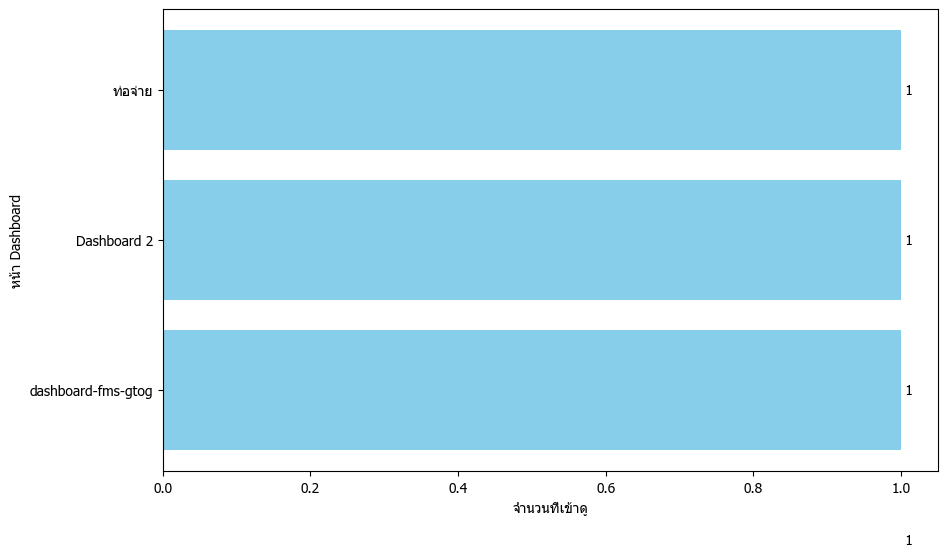

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Specify the URL to fetch JSON data
url = "http://localhost:1234/report-service/api/v1/tableau/Top5_View_Dashboard?month=12&year=2023"

# Add Bearer token to the request headers
headers = {
    'Authorization': 'Bearer POPPOPNIX',  # Replace '1234' with your actual token
}

# Fetch JSON data from the URL with headers
response = requests.get(url, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    json_data = response.json()
    
    # Extract the 'data' key from the JSON data
    data_list1 = json_data.get('total_runs', {}).get('data', [])

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data_list1)
# สร้างกราฟแนวนอน
# สร้างกราฟแนวนอน
plt.figure(figsize=(10, 6))
plt.barh(df['title'], df['view_count'], color='skyblue')
plt.xlabel('จำนวนที่เข้าดู')
plt.ylabel('หน้า Dashboard')
plt.gca().invert_yaxis()  # เรียงลำดับจากมากไปน้อย

# ปรับแต่งคำอธิบายด้านข้างของกราฟ
for i, count in enumerate(df['view_count']):
    plt.text(count, i, f' {count}', va='center')
# plt.savefig('top_5_views.png')
ax.invert_yaxis()

# ax.set_title('Load time of top 10 most view dashboards')
ax.grid()
# ax.get_axisbelow()
plt.show()
